### Import libraries

In [766]:
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from skimage.filters import try_all_threshold, median, threshold_otsu, threshold_mean
from skimage.morphology import disk
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from skimage.util import img_as_ubyte
import glob
import os
import time

In [599]:
import warnings
warnings.filterwarnings('ignore')

## 1. Preprocess and apply DBSCAN clustering on a single image

The dataset consist of imaging mass cytometry (IMC) data from patients with pancreatic cancer. First, import one image of the pan-Keratin marker

In [654]:
# read image
path = '/Users/kim/Documents/Imaging Mass Cytometry Project/PDAC aquisition files/20190517_PDAC56841/05172019_56841PDAC/ROI001_ROI 01/148Nd_pan-Keratin.ome.tiff'
img = io.imread(path)

# some image properties
print(img.dtype)
print(type(img))
print("min:", img.min(), "max:", img.max())

float32
<class 'numpy.ndarray'>
min: 0.0 max: 13447.424


### Preprocessing

Normalize the image

float32
min: 0.0 max: 1.0


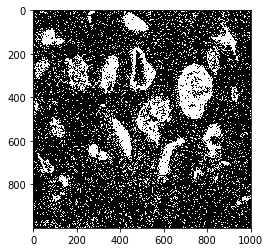

In [655]:
img = rescale_intensity(img, in_range=(0, 1))

# some image properties
print(img.dtype)
print("min:", img.min(), "max:", img.max())

# visualize image
plt.imshow(img, cmap='gray')

Denoising / Filtering

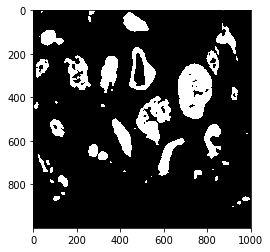

In [656]:
# apply a median filter for denoising
median_img = median(img, disk(7))
plt.imshow(median_img, cmap='gray')

Thresholding

121


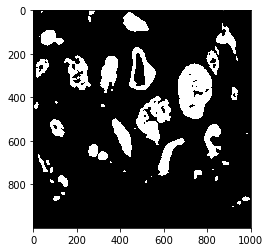

In [657]:
# apply automatic thresholding to get a binary image 
# Otsu thesholding was used to preserve edges
if (np.unique(median_img).size != 1):
    thresh = threshold_otsu(median_img)
    print(thresh)
else:
    thresh = 0
    
binary = median_img > thresh
plt.imshow(binary, cmap='gray')

In [658]:
# binary is our binary image of one's and zero's after thresholding
# this is the total number of pixels with one's values in our image 
binary.sum()

141895

Transform image to vector size - Store in vector the indexes of the pixels with one's value. This vector will be the input to the clustering method next

In [659]:
# original shape of the image
print(binary.shape)

(1000, 1001)


In [660]:
# vectorization - use the binary image to create the vector  
(rows,cols) = binary.shape
vector = []
for row in range(rows):
    for col in range(cols):
        if(binary[row,col] == 1):
            vector.append([row,col])

if len(vector) == 0:
    vector.append([0,0])

In [661]:
# the resulting shape of the vector should be the same as the binary.sum()
vector = np.asarray(vector)
print(vector.shape)
vector

(141895, 2)


array([[  0, 258],
       [  0, 259],
       [  0, 260],
       ...,
       [999, 243],
       [999, 244],
       [999, 245]])

### Clustering algorithm 

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. 

In [676]:
# define dbscan function which takes the vector as input 
def dbscan(vector):
    X = vector
    # standarize image 
    X = StandardScaler().fit_transform(X)

    # Compute DBSCAN
    # use epsilon = 0.05 and minimum_points = 5
    db = DBSCAN(eps=0.05, min_samples=5, metric='euclidean').fit(X)

    # core_samples_mask is True for the indices that are part of a cluster 
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    # labels is a vector with the same lenght as X
    # it has numbers from -1 to k, where k is the number of clusters found
    # -1 is noise
    labels = db.labels_

    return(X, labels, core_samples_mask)

In [677]:
# call dbscan function using the vector as input
X, labels, core_samples_mask = dbscan(vector)

# get resulting number of clusters
n_clusters_ = len(set(labels))

In [664]:
# calculate Davies-Bouldin index for model evaluation
db_index = metrics.davies_bouldin_score(X, labels)
print("Davies-Bouldin Index: %0.3f" % db_index)

Davies-Bouldin Index: 0.445


In [665]:
# define a function to plot the resulting clusters with different color tones 
def plot_clusters(X, labels, core_samples_mask):
    unique_labels = set(labels)

    # array of same size as unique_labels with colors
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        # binary array, True where label is k
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col), markeredgecolor=tuple(col), markersize=1)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col), markeredgecolor=tuple(col), markersize=1)
    
    #plt.title('Clusters: %d' % n_clusters_)

Text(0.5, 1.0, 'Estimated number of clusters: 41')

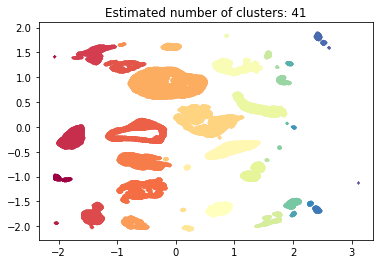

In [678]:
# resulting plot of clusters from the pan-Keratin image
plot_clusters(X, labels, core_samples_mask)
plt.title('Estimated number of clusters: %d' % n_clusters_)

In [635]:
# get some measurements for analysis 
# for example, size of each cluster

unique, unique_count = np.unique(labels, return_counts=True)
print('Sum:', unique_count.sum())
print(unique_count)

Sum: 141895
[  887    17    58  6890  5390  5012  3830 10614  9504  9320  3043 29495
  1362 17626   109   481   250  8012  3651  7052    58  7731  3777  1909
   511    65    55  1098    79  1900    23   264   104   834   846    26
    12]


In [636]:
# store measurements in a dictionary 
measures = {}
measures['db_index'] = db_index
measures['number_of_clusters'] = n_clusters_
measures['size_of_clusters'] = unique_count
measures

{'db_index': 0.4449687925736487,
 'number_of_clusters': 37,
 'size_of_clusters': array([  887,    17,    58,  6890,  5390,  5012,  3830, 10614,  9504,
         9320,  3043, 29495,  1362, 17626,   109,   481,   250,  8012,
         3651,  7052,    58,  7731,  3777,  1909,   511,    65,    55,
         1098,    79,  1900,    23,   264,   104,   834,   846,    26,
           12])}

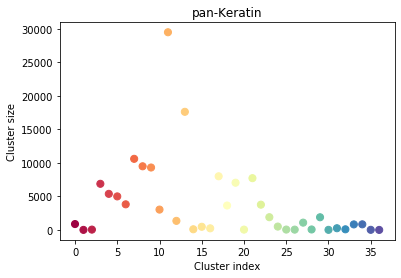

In [637]:
# plot the clusters size for the pan-Keratin image
cluster_index = np.array(range(0, measures['number_of_clusters']))
cluster_size = np.array(measures['size_of_clusters'])
colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique))]
plt.scatter(cluster_index, cluster_size, color = tuple(colors), marker = "o", s = 50) 
# x-axis label 
plt.xlabel('Cluster index') 
# frequency label 
plt.ylabel('Cluster size') 
# plot title 
plt.title('pan-Keratin') 
plt.show() 

## 2. Preprocess and apply DBSCAN clustering to the entire dataset

In [761]:
# define function to read all images from path
def load_images(path):
    # loads all ome.tiff images from path 
    # extracts filenames
    extension = '.ome.tiff'
    images = {}
    
    # for each image, extract image name and use as key 
    # store image in the images dictionary
    for file in glob.glob(path):
        if file.endswith('.ome.tiff'):
            filename = os.path.basename(file)
            filename = filename[:len(filename)-len(extension)]
            #print(filename)
            img = io.imread(file)
            img = rescale_intensity(img, in_range=(0, 1))
            images[filename] = img
    return(images)

In [701]:
# try one path that contains 46 images that correspond to 46 of the markers
path = '/Users/kim/Documents/Imaging Mass Cytometry Project/PDAC aquisition files/20190517_PDAC56841/05172019_56841PDAC/ROI001_ROI 01/*'
images = load_images(path)

170Yb_CD3
113In_113In
175Lu_PP
158Gd_NKX6.1
193Ir_DNA
145Nd_C-peptide
156Gd_CD4
164Dy_CD99
172Yb_pS6
138Ba_138Ba
146Nd_Nestin
161Dy_CD20
163Dy_163Dy
191Ir_DNA
133Cs_133Cs
162Dy_CD8
159Tb_CD68
139La_139La
115In_115In
151Eu_PDX-1
208Pb_208Pb
167Er_GnzB
169Tm_Collagen
134Xe_134Xe
166Er_NFkb
149Sm_CD11b
165Ho_CA2
152Sm_CD45
173Yb_CD45RO
155Gd_Foxp3
143Nd_CD31
160Gd_Somatostatin
147Sm_Glucagon
141Pr_HLA-ABC
120Sn_120Sn
142Nd_CD57
176Yb_GHRL
153Eu_CD56
150Nd_CD44
154Sm_beta-Actin
171Yb_171Yb
168Er_Ki67
148Nd_pan-Keratin
174Yb_HLA-DR
127I_127I
144Nd_CD14


In [702]:
# number of images in this path
len(images)

46

Plot the images

In [703]:
def plot_images(images):
    fig = plt.figure(figsize=(15, 15))
    columns = 7
    rows = 7
    index = 1
    
    for key in images:
        img = images[key]
        a = fig.add_subplot(rows, columns, index)
        a.set_title(key)
        plt.imshow(img, cmap='gray')
        index += 1
    
    plt.tight_layout(pad=1.0)
    plt.show()

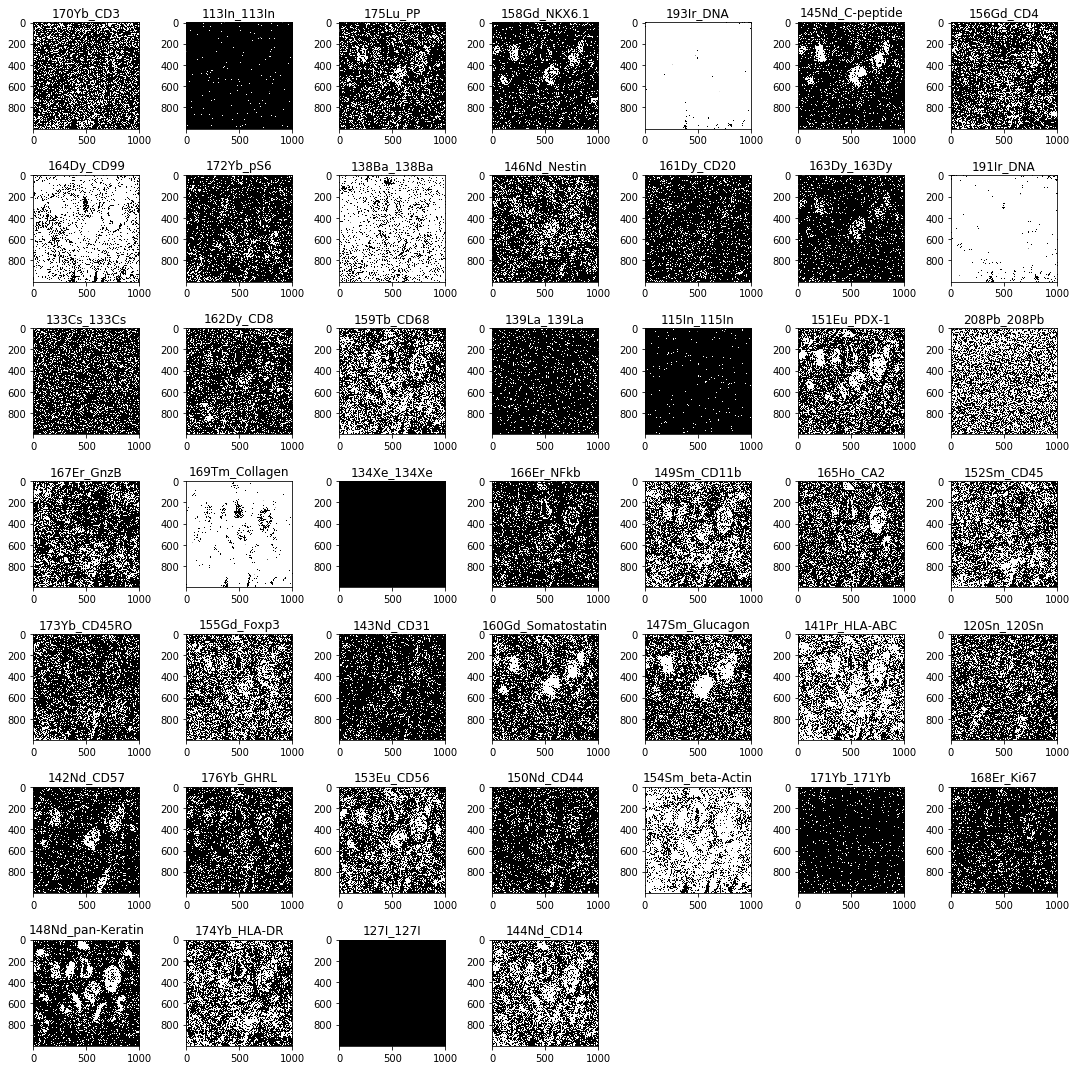

In [704]:
# plot the images of the path that was imported 
plot_images(images)

In [642]:
# define a function with the same preprocessing steps perfomed before 
def denoise_and_segment(img):
    # using median filter and otsu threasholding
    median_img = median(img, disk(7))
    
    if (np.unique(median_img).size != 1):
        thresh = threshold_otsu(median_img)
    else:
        thresh = 0
    
    binary = median_img > thresh    
    return(binary)

In [643]:
# define a function for the vectorization of the image, same as before 
def transform_to_vector(binary_img):
    (rows,cols) = binary_img.shape
    vector = []
    
    # add to vector the pixels with value = True 
    for row in range(rows):
        for col in range(cols):
            if(binary[row,col] == 1):
                vector.append([row,col])
            if len(vector) == 0:
                vector.append([0,0])
                
    vector = np.asarray(vector)    
    return(vector)

In [644]:
# deinfe a function to make the measurements from the clustering results for analysis 
def make_measurements(X, labels):
    n_clusters_ = len(set(labels))
    
    if n_clusters_ > 1:
        db_index = metrics.davies_bouldin_score(X, labels)
    else: 
        db_index = None
    
    # size of clusters
    unique, unique_count = np.unique(labels, return_counts=True)
    
    measures = {}
    measures['db_index'] = db_index
    measures['number_of_clusters'] = n_clusters_
    measures['size_of_clusters'] = unique_count
    
    return measures

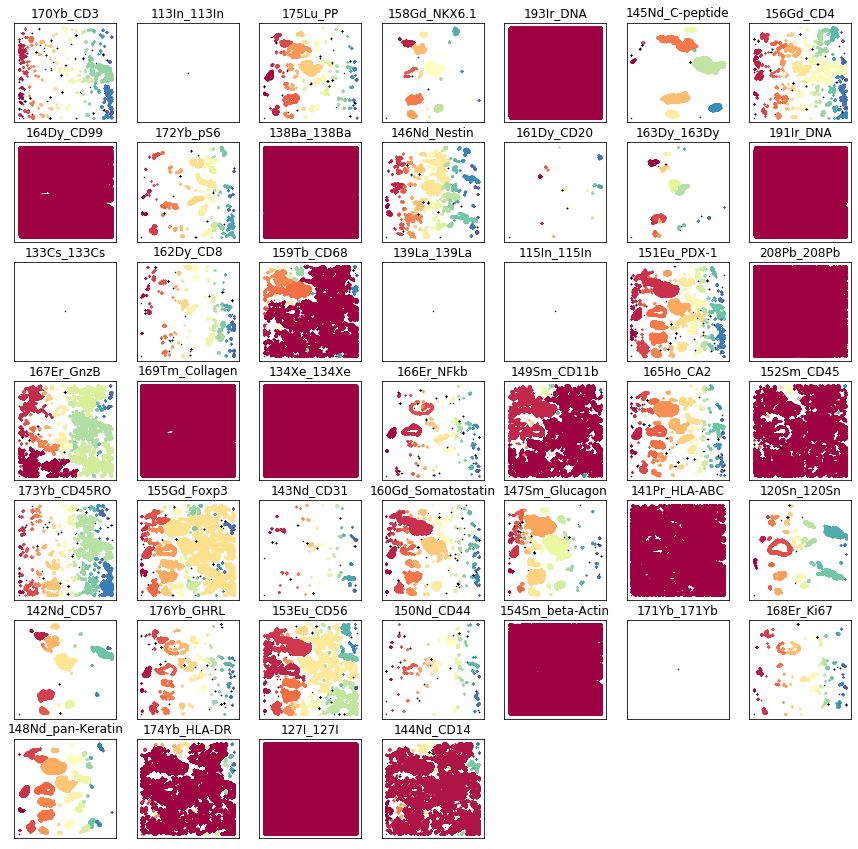

In [647]:
# apply the defined functions to the images of the path 
# and plot the result 
# each color tone represents a different cluster

fig = plt.figure(figsize=(15, 15))
columns = 7
rows = 7
index = 1
PDAC56841_ROI01 = {}

for key in images:
    img = images[key]
    
    # preprocessing
    binary = denoise_and_segment(img)
    vector = transform_to_vector(binary)
    
    # apply dbscan clustering
    (X, labels, core_samples_mask) = dbscan(vector)
    
    # call function to make measurements from resulting clustering
    PDAC56841_ROI01[key] = make_measurements(X, labels)
    
    # plot result 
    a = fig.add_subplot(rows, columns, index)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    a.set_title(key)
    plot_clusters(X, labels, core_samples_mask)
    index += 1

Plot number of clusters of images

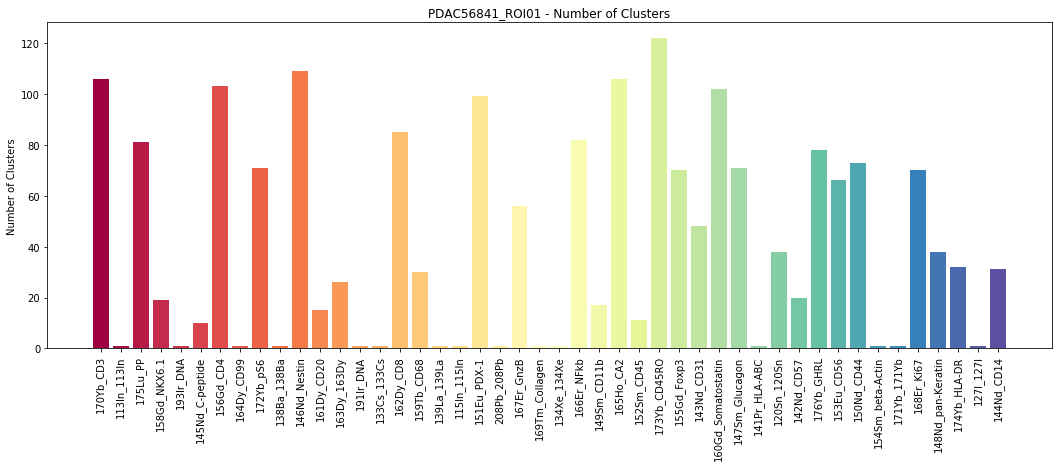

In [680]:
labels = []
number_of_clusters = []
#print(labels)

for key in PDAC56841_ROI01: 
    labels.append(key)
    img_measure = PDAC56841_ROI01[key]
    number_of_clusters.append(img_measure['number_of_clusters'])

colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(set(labels)))]

# plotting a bar chart 
fig = plt.figure(figsize=(18, 6))
plt.bar(labels, number_of_clusters, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Number of Clusters') 
# plot title 
plt.title('PDAC56841_ROI01 - Number of Clusters') 
  
# function to show the plot 
plt.show()

Plot Davies-Bouldin Index

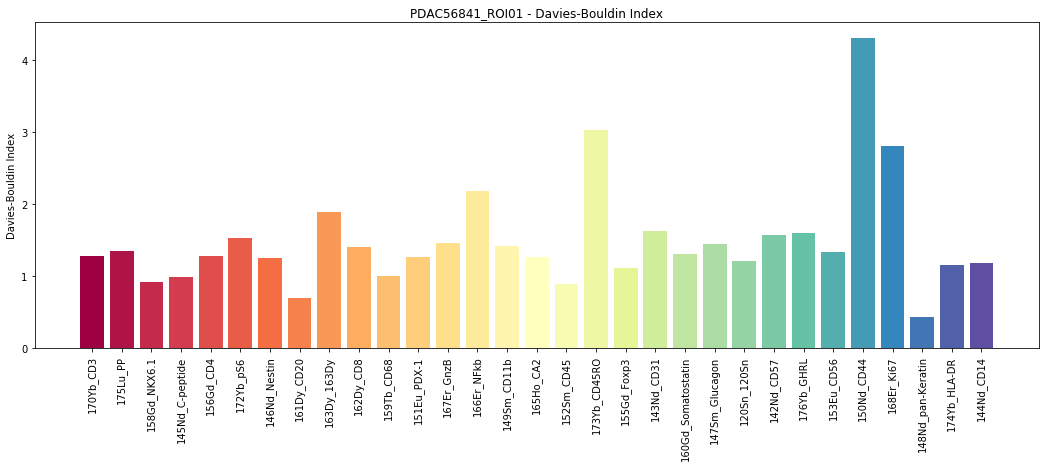

In [681]:
labels = []
db_index = []

for key in PDAC56841_ROI01: 
    img_measure = PDAC56841_ROI01[key]
    if(img_measure['db_index'] != None):
        labels.append(key)
        db_index.append(img_measure['db_index'])

colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(set(labels)))]

# plotting a bar chart 
fig = plt.figure(figsize=(18, 6))
plt.bar(labels, db_index, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Davies-Bouldin Index') 
# plot title 
plt.title('PDAC56841_ROI01 - Davies-Bouldin Index') 
  
# function to show the plot 
plt.show()

### Read all ROIs (all the paths from the entire dataset)

The dataset consists of 9 folders, with a total of 36 regions of interest (ROIs). Each ROI has 46 images, resulting in a total of 1,656 images.  

In [759]:
path = '/Users/kim/Documents/Imaging Mass Cytometry Project/PDAC aquisition files/*/*/*'
short_path = '/Users/kim/Documents/Imaging Mass Cytometry Project/PDAC aquisition files/'

# paths for ROIs folders - Total: 36 ROIs
rois_paths = []
rois_ids = []

# get ROIs path and ROIs ids for all folders in path  
for folder in glob.glob(path):
    rois_paths.append(folder + '/*')
    
    # take the end of the path as a ROI id 
    # use it as key in the dictionary
    roi_name = folder.replace(short_path, '')
    roi_name = roi_name[19:len(roi_name)]
    rois_ids.append(roi_name)
    
print(rois_paths[0])
print(rois_ids)
print(len(rois_ids))

/Users/kim/Documents/Imaging Mass Cytometry Project/PDAC aquisition files/20190718_PDAC65715/20190718_DPAC_65715/ROI003_ROI 03/*
['20190718_DPAC_65715/ROI003_ROI 03', '20190718_DPAC_65715/ROI004_ROI 04', '20190718_DPAC_65715/ROI001_ROI 01', '20190718_DPAC_65715/ROI002_ROI 02', '20190703_PDAC65290/ROI003_ROI 03', '20190703_PDAC65290/ROI004_ROI 04', '20190703_PDAC65290/ROI001_ROI 01', '20190703_PDAC65290/ROI002_ROI 02', '20190715_PDAC_65289/ROI003_ROI 03', '20190715_PDAC_65289/ROI004_ROI 04', '20190715_PDAC_65289/ROI001_ROI 01', '20190715_PDAC_65289/ROI002_ROI 02', '20190520_PDAC59121/ROI006_ROI 06', '20190520_PDAC59121/ROI004_ROI 01_resumed', '20190520_PDAC59121/ROI005_ROI 05', '20190520_PDAC59121/ROI007_ROI 07', '20190520_PDAC59121/ROI001_ROI 01', '20190718_DPAC_79359/ROI003_ROI 03', '20190718_DPAC_79359/ROI004_ROI 04', '20190718_DPAC_79359/ROI001_ROI 01', '20190718_DPAC_79359/ROI002_ROI 02', '05172019_56841PDAC/ROI003_ROI 03', '05172019_56841PDAC/ROI001_ROI 01', '05172019_56841PDAC/RO

Apply clustering algorithm for all ROIs

In [778]:
rois_measures = {}
rois_time = []

# for each ROI in rois_paths
for i in range(len(rois_paths)):
    print("Current ROI:", i)
    start = time.time()
    images = load_images(rois_paths[i])
    roi_results = {}

    # for each image in the current ROI
    for key in images:
        img = images[key]
        
        # preprocess image
        binary = denoise_and_segment(img)
        vector = transform_to_vector(binary)
        
        # apply DBSCAN
        (X, labels, core_samples_mask) = dbscan(vector)
        
        # take measurements from DBSCAN result of the current ROI
        # store in a dictionary roi_results 
        roi_results[key] = make_measurements(X, labels)
    
    # add rois_results to rois_measures dictionary 
    # name the key after the ID from rois_ids 
    name = rois_ids[i]
    rois_measures[name] = roi_results
    
    # measure time of processing for each ROI 
    end = time.time()
    rois_time.append(end - start)
    print("ROI", i, "time:", end - start)

Current ROI: 0
ROI 0 time: 226.7622902393341
Current ROI: 1
ROI 1 time: 266.3166391849518
Current ROI: 2
ROI 2 time: 775.9150211811066
Current ROI: 3
ROI 3 time: 656.2113540172577
Current ROI: 4
ROI 4 time: 1131.7270557880402
Current ROI: 5
ROI 5 time: 569.4821240901947
Current ROI: 6
ROI 6 time: 1546.1934869289398
Current ROI: 7
ROI 7 time: 1297.438136100769
Current ROI: 8
ROI 8 time: 269.0419280529022
Current ROI: 9
ROI 9 time: 319.99317598342896
Current ROI: 10
ROI 10 time: 940.0953221321106
Current ROI: 11
ROI 11 time: 518.5955650806427
Current ROI: 12
ROI 12 time: 282.15189599990845
Current ROI: 13
ROI 13 time: 477.68964767456055
Current ROI: 14
ROI 14 time: 335.32800102233887
Current ROI: 15
ROI 15 time: 318.0748391151428
Current ROI: 16
ROI 16 time: 85.92935800552368
Current ROI: 17
ROI 17 time: 1091.8663280010223
Current ROI: 18
ROI 18 time: 93.71775674819946
Current ROI: 19
ROI 19 time: 662.1090941429138
Current ROI: 20
ROI 20 time: 757.0612368583679
Current ROI: 21
ROI 21 tim

In [791]:
print(len(rois_measures))
print(len(rois_measures[rois_names[0]]))

36
46


Measures of Clusters for all ROIs - Pan-Keratin

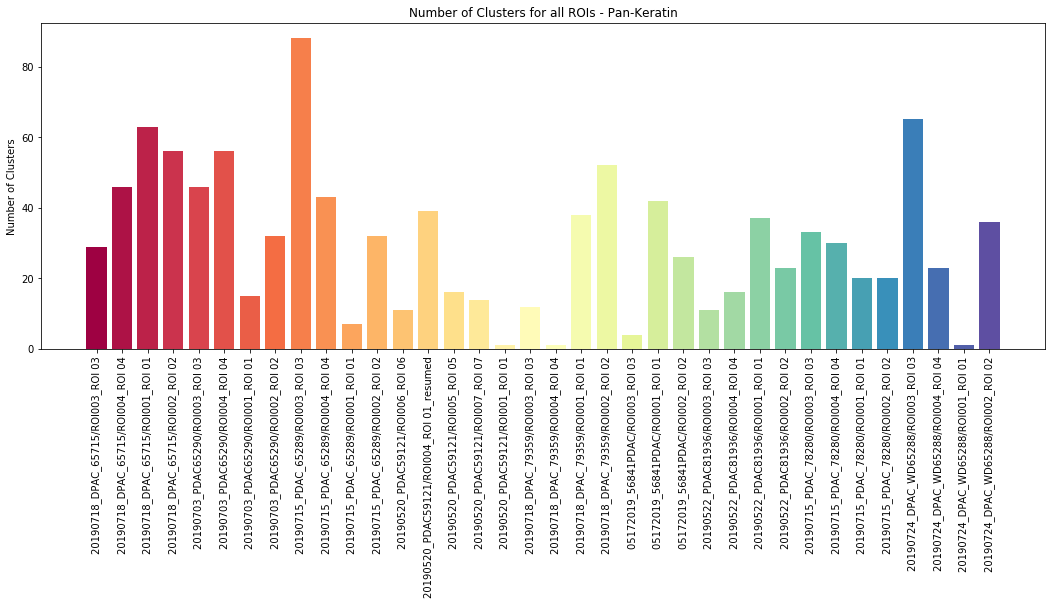

In [809]:
# plot the number of clusters found for all pan-Keratin images frmo all ROIs
labels = []
pk_number_of_clusters = []
pk_area_of_clusters = []

for roi in rois_measures: 
    labels.append(roi)
    roi_measure = rois_measures[roi]
    pan_keratin = roi_measure['148Nd_pan-Keratin']
    pk_number_of_clusters.append(pan_keratin['number_of_clusters'])
    pk_area_of_clusters.append(sum(pan_keratin['size_of_clusters']))

colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(set(labels)))]

# plotting a bar chart 
fig = plt.figure(figsize=(18, 6))
plt.bar(labels, pk_number_of_clusters, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Number of Clusters') 
# plot title 
plt.title('Number of Clusters for all ROIs - Pan-Keratin') 
  
# function to show the plot 
plt.show()

In [810]:
pk_area_of_clusters

[38316,
 100306,
 100122,
 136644,
 339931,
 59206,
 6434,
 159839,
 150139,
 38751,
 677,
 338437,
 12800,
 120052,
 220835,
 137284,
 1,
 582800,
 1,
 424553,
 250956,
 703,
 141896,
 54161,
 2519,
 371758,
 293507,
 106373,
 438752,
 29237,
 16209,
 161716,
 18312,
 1178,
 46,
 31096]

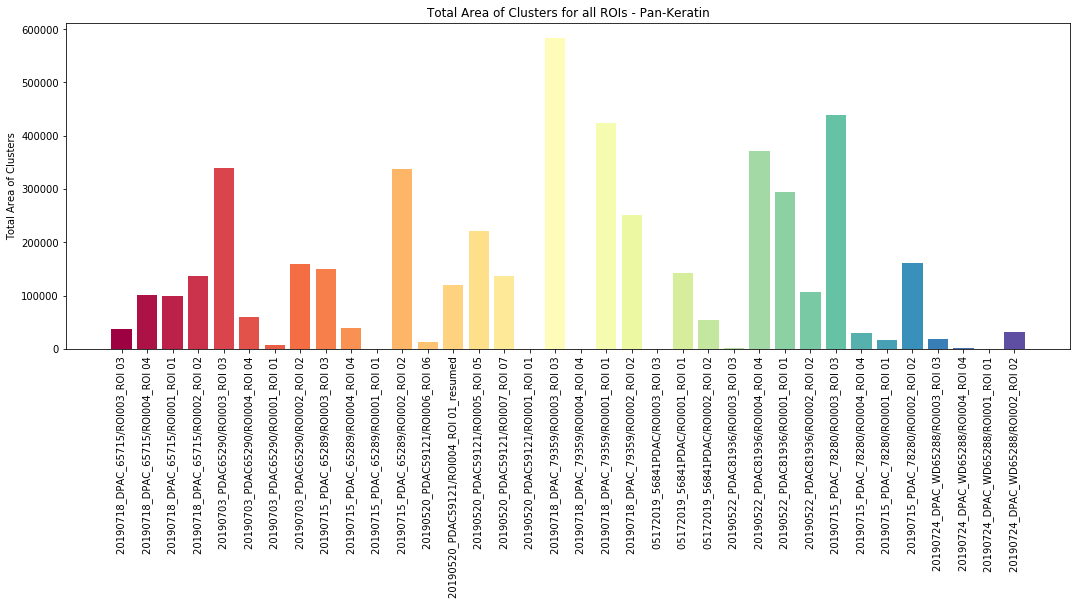

In [811]:
# plotting the total area of clusters for all pan-Keratin images from all ROIs
fig = plt.figure(figsize=(18, 6))
plt.bar(labels, pk_area_of_clusters, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Total Area of Clusters') 
# plot title 
plt.title('Total Area of Clusters for all ROIs - Pan-Keratin') 
  
# function to show the plot 
plt.show()

Get ratio between pan-Keratin and CD3

In [827]:
labels = []
cd3_number_of_clusters = []
cd3_area_of_clusters = []

# get CD3 measurements
for roi in rois_measures: 
    labels.append(roi)
    roi_measure = rois_measures[roi]
    cd3 = roi_measure['170Yb_CD3']
    cd3_number_of_clusters.append(cd3['number_of_clusters'])
    cd3_area_of_clusters.append(sum(cd3['size_of_clusters']))

# get ratio between number of clusters
ratio_number_of_clusters = [i / j for i, j in zip(pk_number_of_clusters, cd3_number_of_clusters)] 

# get ratio between area of clusters
ratio_area_of_clusters = [i / j for i, j in zip(pk_area_of_clusters, cd3_area_of_clusters)] 


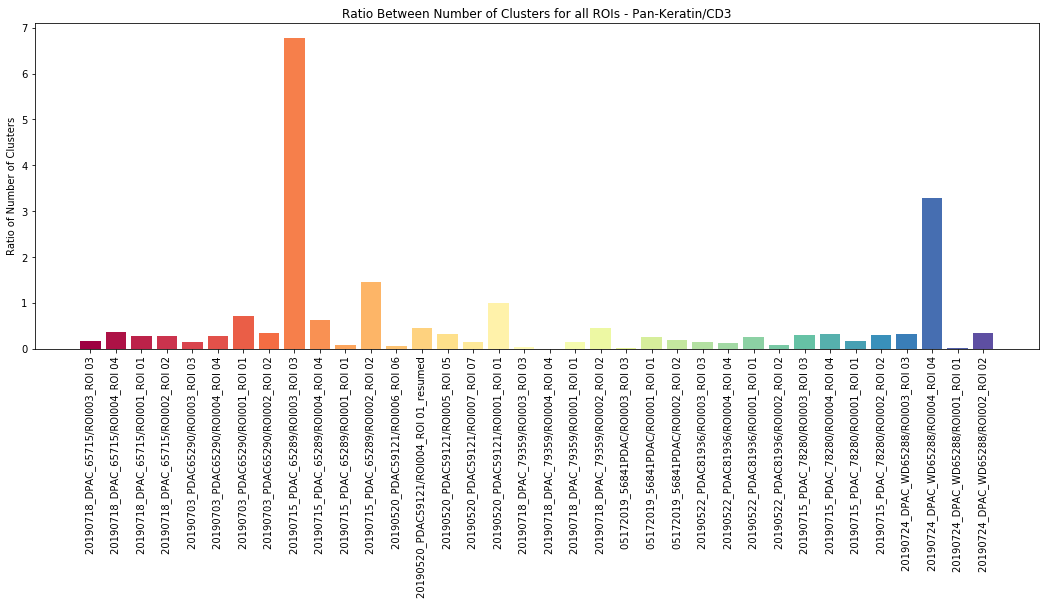

In [821]:
# plotting a bar chart with the ration between the number of clusters
# of pan-Keratin and CD3 images 
fig = plt.figure(figsize=(18, 6))
plt.bar(labels, ratio_number_of_clusters, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Ratio of Number of Clusters') 
# plot title 
plt.title('Ratio Between Number of Clusters for all ROIs - Pan-Keratin/CD3') 
  
# function to show the plot 
plt.show()

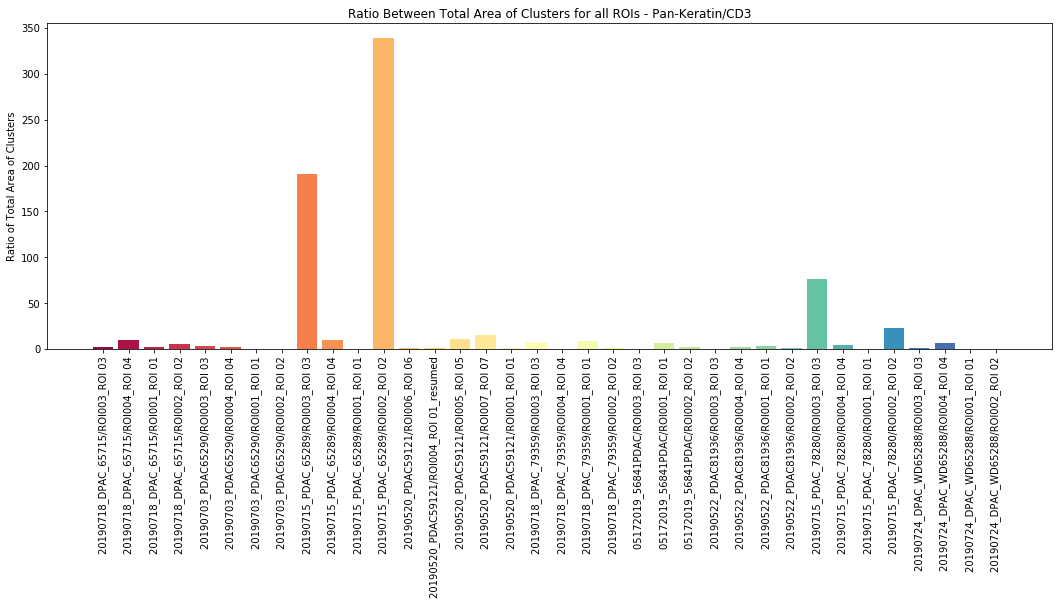

In [828]:
# plotting a bar chart with the ration between the total area of clusters
# of pan-Keratin and CD3 images fig = plt.figure(figsize=(18, 6))
plt.bar(labels, ratio_area_of_clusters, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Ratio of Total Area of Clusters') 
# plot title 
plt.title('Ratio Between Total Area of Clusters for all ROIs - Pan-Keratin/CD3') 
  
# function to show the plot 
plt.show()

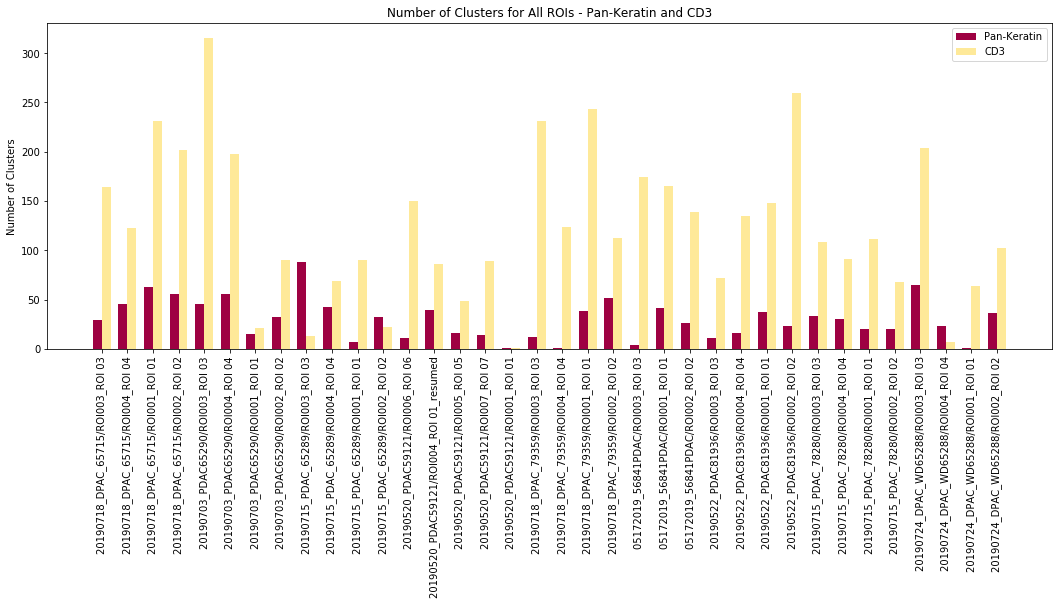

In [849]:
# plotting a bar chart with the number of clusters
# of pan-Keratin and CD3 images for all ROIs
N = len(pk_number_of_clusters)
ind = np.arange(N)  # the x locations for the bars
width = 0.35      # the width of the bars

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, pk_number_of_clusters, width, color=colors[0])

rects2 = ax.bar(ind+width, cd3_number_of_clusters, width, color=colors[15])

# add some
ax.set_ylabel('Number of Clusters')
ax.set_title('Number of Clusters for All ROIs - Pan-Keratin and CD3')
ax.set_xticks(ind + width / 2)
plt.xticks(rotation='vertical')  
ax.set_xticklabels(labels)

ax.legend( (rects1[0], rects2[0]), ('Pan-Keratin', 'CD3') )
plt.show()

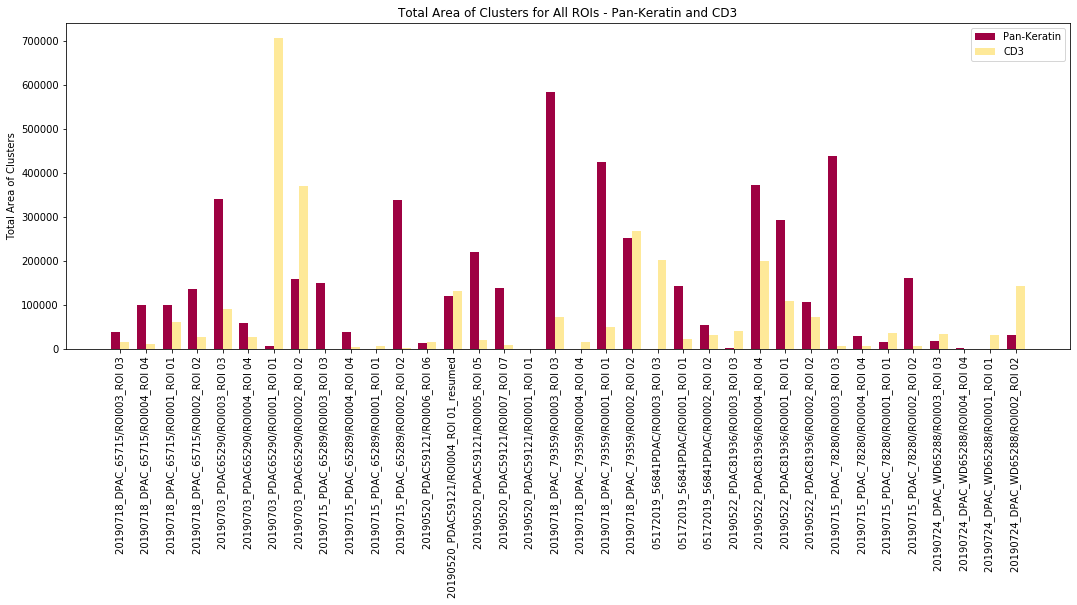

In [847]:
# plotting a bar chart with the total area of clusters
# of pan-Keratin and CD3 images for all ROIs
N = len(pk_area_of_clusters)
ind = np.arange(N)  # the x locations for the bars
width = 0.35      # the width of the bars

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, pk_area_of_clusters, width, color=colors[0])

rects2 = ax.bar(ind+width, cd3_area_of_clusters, width, color=colors[15])

# add some
ax.set_ylabel('Total Area of Clusters')
ax.set_title('Total Area of Clusters for All ROIs - Pan-Keratin and CD3')
ax.set_xticks(ind + width / 2)
plt.xticks(rotation='vertical')  
ax.set_xticklabels(labels)

ax.legend( (rects1[0], rects2[0]), ('Pan-Keratin', 'CD3') )
plt.show()

Get average of db_index for all ROIs

In [856]:
labels = []
average_db_index_all_rois = []

for roi in rois_measures: 
    labels.append(roi)
    roi_measure = rois_measures[roi]
    db_indexes = []
    for marker in roi_measure:
        if roi_measure[marker]['db_index'] != None:
            db_indexes.append(roi_measure[marker]['db_index'])
    average_db_index_all_rois.append(sum(db_indexes)/len(db_indexes))

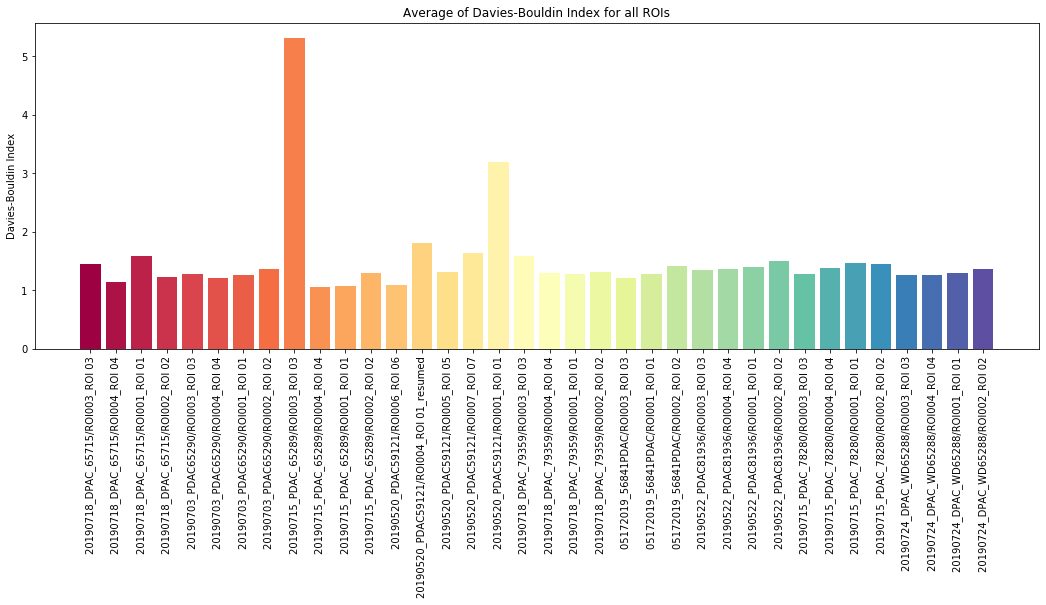

In [860]:
# plotting a bar chart 
fig = plt.figure(figsize=(18, 6))
plt.bar(labels, average_db_index_all_rois, tick_label = labels, 
        width = 0.8, color = tuple(colors)) 

plt.xticks(rotation='vertical')  
# naming the y-axis 
plt.ylabel('Davies-Bouldin Index') 
# plot title 
plt.title('Average of Davies-Bouldin Index for all ROIs') 
  
# function to show the plot 
plt.show()